In [75]:
# Import necessary modules and functions
# test
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from datetime import datetime
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')
cols = ['project_id', 'blurb', 'category', 'country', 'created_at', 'currency', 'deadline', 'fx_rate', 'goal',
'launched_at', 'name', 'staff_pick', 'location', 'subcategory', 'project_url', 'reward_url']

In [76]:
df = pd.read_csv('KS_train_data.csv', delimiter=',')
#df_test = pd.read_csv('KS_test_data.csv', delimiter=';')

In [77]:
df.columns

Index(['project_id', 'backers_count', 'blurb', 'category',
       'converted_pledged_amount', 'country', 'created_at', 'currency',
       'deadline', 'fx_rate', 'goal', 'launched_at', 'name', 'pledged',
       'staff_pick', 'usd_pledged', 'location', 'funded', 'subcategory',
       'project_url', 'reward_url'],
      dtype='object')

In [78]:
print(datetime.fromtimestamp(df.iloc[1].created_at))

2012-03-05 05:41:24


In [79]:
df['delta_time_created'] = df.deadline - df.created_at
df['delta_time_launched'] = df.deadline - df.launched_at

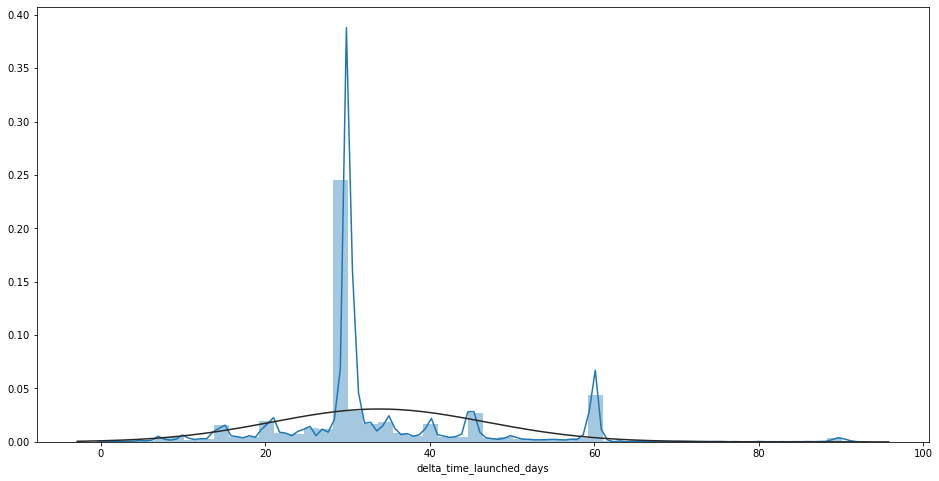

In [80]:
df['delta_time_launched_days'] = df.delta_time_launched / 86400
df['delta_time_created_days'] = df.delta_time_launched / 86400

sns.distplot(df.delta_time_launched_days, fit=norm)


In [81]:
# df[cols].info()
# df_test.info()

In [82]:
total_funded = df.loc[(df.funded==True), 'funded'].value_counts()

In [83]:
funded_staff_pick = df.loc[(df.funded==True) & (df.staff_pick == True), 'staff_pick'].value_counts() / total_funded
funded_staff_pick
# means that about 80% of those funded were not staff picked


True    0.213553
dtype: float64

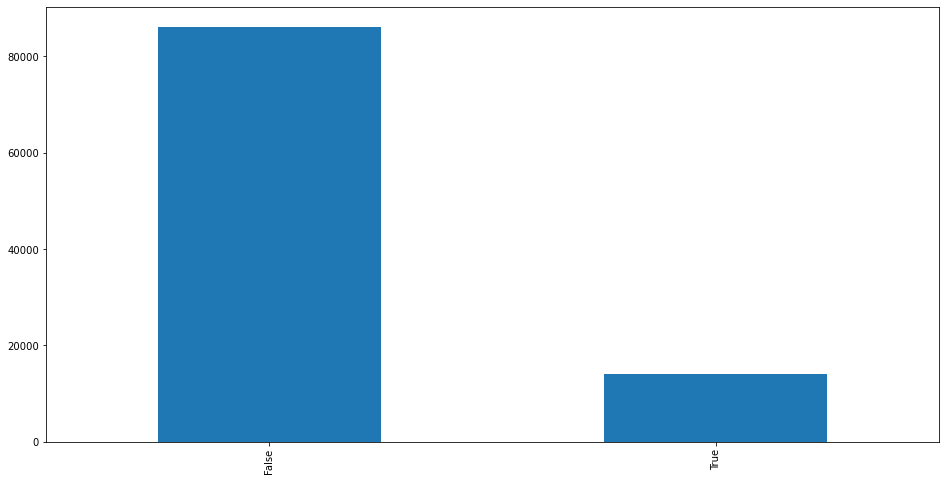

In [84]:
df['staff_pick'].value_counts().plot(kind='bar')

In [85]:
df['goal_converted_log'] = np.log(df.goal * df.fx_rate)


Text(0.5, 1.0, 'Funded vs unfunded converted log goals')

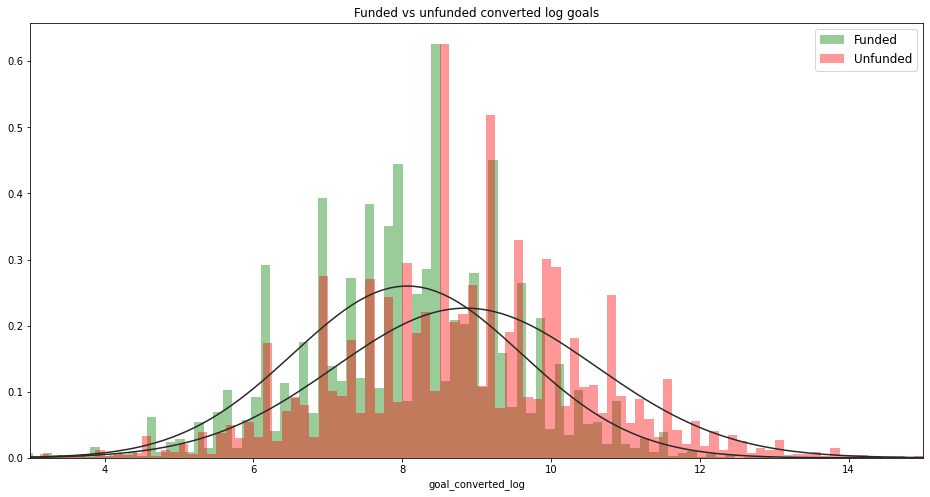

In [86]:
funded = df.loc[df.funded == True]
not_funded = df.loc[df.funded == False]

dplot = sns.distplot(funded.goal_converted_log, kde=False, color='green', bins=150, hist=True, fit=norm, label='Funded')
dplot = sns.distplot(not_funded.goal_converted_log, kde=False, color='red', bins=150, hist=True, fit=norm, label='Unfunded')
dplot.set(xlim=(3,15))
dplot.legend(prop={'size': 12})
dplot.set_title('Funded vs unfunded converted log goals')

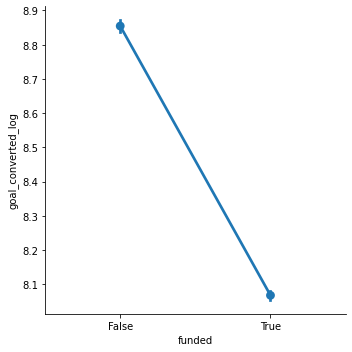

In [87]:
sns.catplot(data=df, x ='funded', y='goal_converted_log', kind='point')

In [88]:
df['goal_per_day'] = df['goal_converted_log'] / df['delta_time_launched']

Text(0.5, 1.0, 'Funded vs unfunded projects by log $/day needed to reach goal')

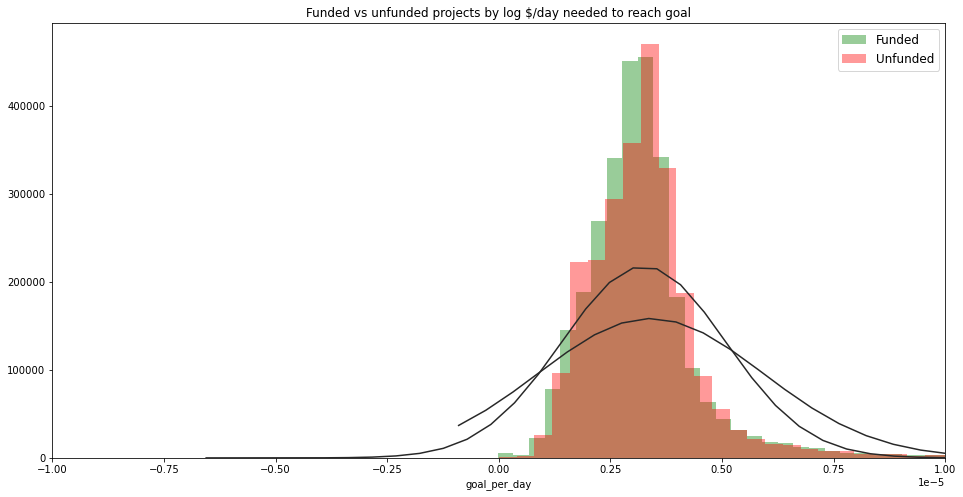

In [89]:
funded = df.loc[df.funded == True]
not_funded = df.loc[df.funded == False]

dplot = sns.distplot(funded.goal_per_day, kde=False, color='green', bins=300, hist=True, fit=norm, label='Funded')
dplot = sns.distplot(not_funded.goal_per_day, kde=False, color='red', bins=300, hist=True, fit=norm, label='Unfunded')
dplot.set(xlim=(-0.00001,.00001))
dplot.legend(prop={'size': 12})
dplot.set_title('Funded vs unfunded projects by log $/day needed to reach goal')

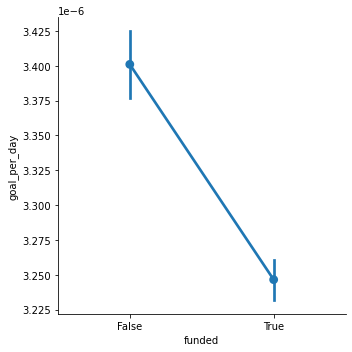

In [90]:
sns.catplot(data=df, x ='funded', y='goal_per_day', kind='point')

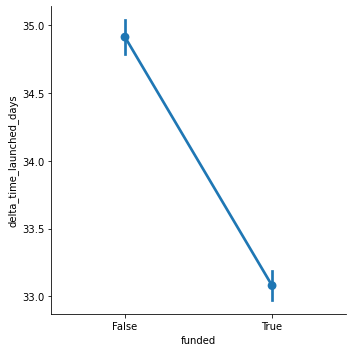

In [91]:
sns.catplot(data=df, x ='funded', y='delta_time_launched_days', kind='point')

In [92]:
# normalize category data
total_in_cat = {}
funded_in_cat = {}
rate_funded_cat = {}
for x in df.category.unique():
    total_in_cat[x] = df.loc[(df.category == x, 'project_id')].count()
    funded_in_cat[x] = df.loc[(df.category == x) & (df.funded == True), 'project_id'].count() 
    rate_funded_cat[x] = funded_in_cat[x] / total_in_cat[x]


In [93]:
rate_funded_cat

{'art': 0.5587666731103809,
 'comics': 0.7601941747572816,
 'crafts': 0.513431934802294,
 'dance': 0.8504453820909517,
 'design': 0.7249434815373021,
 'fashion': 0.44222571236257574,
 'film & video': 0.618456476218965,
 'food': 0.36252280427417255,
 'games': 0.6277122842986502,
 'journalism': 0.3084886128364389,
 'music': 0.6800056461288729,
 'photography': 0.5552989479086476,
 'publishing': 0.7209627484270449,
 'technology': 0.3862853863810253,
 'theater': 0.7510548523206751}

<BarContainer object of 15 artists>

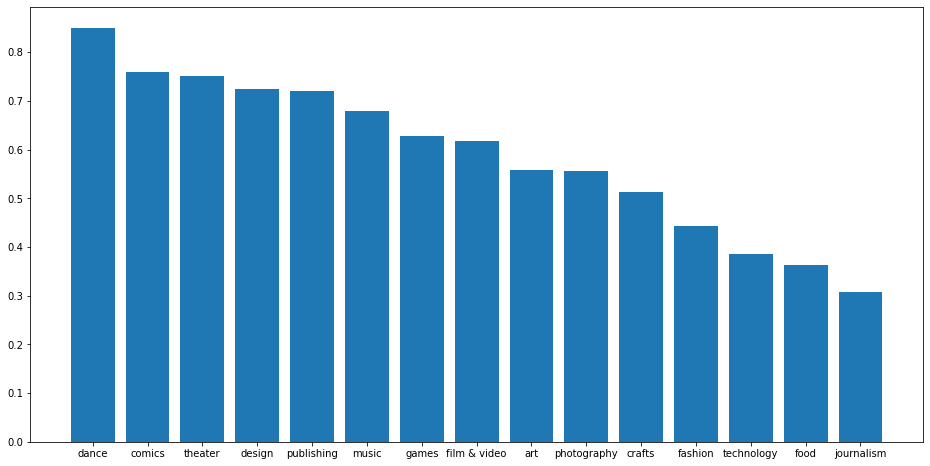

In [94]:
sorted_rate_funded_cat = sorted(rate_funded_cat.items(), key=lambda x: x[1], reverse=True)
plt.bar([x[0] for x in sorted_rate_funded_cat], [y[1] for y in sorted_rate_funded_cat])
#plt.bar(rate_funded_cat.keys(), rate_funded_cat.values())

In [95]:
df['rate_funded_cat'] = df.apply(lambda row: rate_funded_cat[row.category], axis=1)

In [96]:
df.loc[df.category == 'art', 'subcategory'].unique()

array(['mixed media', 'public art', 'sculpture', 'art', 'painting',
       'conceptual art', 'digital art', 'performance art', 'illustration',
       'ceramics', 'installations', 'video art', 'textiles'], dtype=object)

In [97]:
total_in_subcat = {}
funded_in_subcat = {}
rate_funded_subcat = {}
for x in df.subcategory.unique():
    total_in_subcat[x] = df.loc[(df.subcategory == x, 'project_id')].count()
    funded_in_subcat[x] = df.loc[(df.subcategory == x) & (df.funded == True), 'project_id'].count() 
    rate_funded_subcat[x] = funded_in_subcat[x] / total_in_subcat[x]

<BarContainer object of 158 artists>

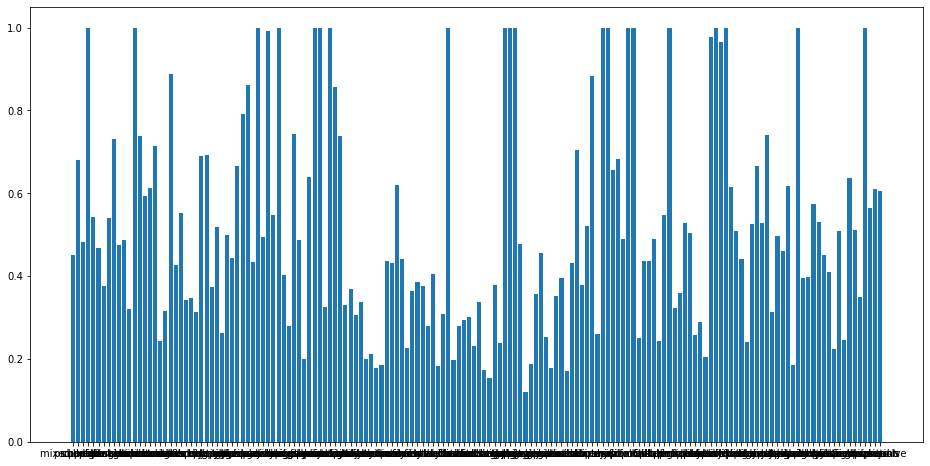

In [98]:
plt.bar(rate_funded_subcat.keys(), rate_funded_subcat.values())

In [99]:
total_in_subcat
#sorted_rate_funded_country

{'mixed media': 1482,
 'public art': 1481,
 'sculpture': 1063,
 'art': 336,
 'painting': 1460,
 'conceptual art': 605,
 'digital art': 705,
 'performance art': 1209,
 'illustration': 1348,
 'ceramics': 168,
 'installations': 250,
 'video art': 100,
 'comics': 1088,
 'comic books': 1365,
 'webcomics': 360,
 'graphic novels': 1013,
 'anthologies': 416,
 'events': 411,
 'textiles': 139,
 'crafts': 722,
 'woodworking': 791,
 'stationery': 165,
 'crochet': 105,
 'embroidery': 69,
 'diy': 665,
 'pottery': 74,
 'knitting': 146,
 'printing': 123,
 'quilts': 52,
 'candles': 258,
 'glass': 76,
 'weaving': 61,
 'taxidermy': 6,
 'performances': 918,
 'residencies': 65,
 'spaces': 481,
 'product design': 1902,
 'graphic design': 1120,
 'dance': 899,
 'workshops': 117,
 'design': 176,
 'civic design': 164,
 'architecture': 364,
 'typography': 66,
 'accessories': 1298,
 'interactive design': 189,
 'apparel': 1283,
 'shorts': 1698,
 'film & video': 146,
 'animation': 1276,
 'documentary': 1687,
 'narr

In [100]:
# needs to be fixed - think it's the null values in country that need to be dropped first
#total_in_country = {}
#funded_in_country = {}
#rate_funded_country = {}
#for x in df.country.unique():
#     total_in_country[x] = df.loc[(df.country == x, 'project_id')].count()
#     funded_in_country[x] = df.loc[(df.country == x) & (df.funded == True), 'project_id'].count() 
#     rate_funded_country[x] = funded_in_country[x] / total_in_country[x]
# sorted_rate_funded_country = sorted(rate_funded_country.items(), key=lambda x: x[1], reverse=True)
# plt.bar([x[0] for x in sorted_rate_funded_country], [y[1] for y in sorted_rate_funded_country])

In [101]:
dum_df = pd.get_dummies(df, columns=["category"], prefix=["cat_typ"] )


In [102]:
cols = ['cat_typ_art', 'cat_typ_comics', 'cat_typ_crafts',
       'cat_typ_dance', 'cat_typ_design', 'cat_typ_fashion',
       'cat_typ_film & video', 'cat_typ_food', 'cat_typ_games',
       'cat_typ_journalism', 'cat_typ_music', 'cat_typ_photography',
       'cat_typ_publishing', 'cat_typ_technology', 'cat_typ_theater', 'rate_funded_cat', 'delta_time_launched_days', 'goal_converted_log', 'staff_pick']
x_train, x_test, y_train, y_test = train_test_split(dum_df[cols], dum_df['funded'], test_size =0.80, random_state=0)
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr.C = 0.01
lgr.fit(x_train, y_train)
score = lgr.score(x_test, y_test)
predictions = lgr.predict(x_test)
print(score)

0.70415


[[17093 16170]
 [ 7498 39239]]


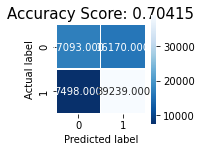

In [103]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [104]:
lgr.get_params()

{'C': 0.01,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [105]:
lgr.solver='newton-cg'
lgr.c = 1
lgr.fit(x_train, y_train)
score = lgr.score(x_test, y_test)
predictions = lgr.predict(x_test)
print(score)

0.70425


In [106]:
from sklearn import preprocessing
lgr.solver='lbfgs'
rb_scaler = preprocessing.RobustScaler()
x_train_rb = rb_scaler.fit_transform(x_train)
rb_scaler.transform(x_test)
lgr.fit(x_train_rb, y_train)
predictions = lgr.predict(x_test)
score = lgr.score(x_test, y_test)
print(score)

0.416175


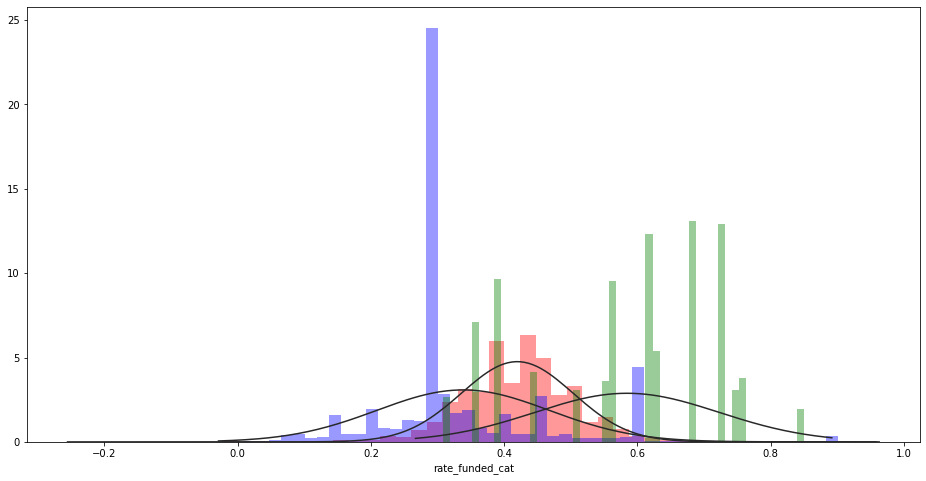

In [107]:
dplot = sns.distplot((df['goal_converted_log'])/20, color='red', kde=False, fit=norm)
dplot = sns.distplot(df['delta_time_launched_days']/100, color='blue', kde=False, fit=norm)
dplot = sns.distplot(df['rate_funded_cat'], color='green', kde=False, fit=norm)


In [108]:
dum_df['goal_scaled'] = df.goal_converted_log / 20
dum_df['time_scaled'] = df.delta_time_launched_days / 100

In [109]:
cols = ['cat_typ_art', 'cat_typ_comics', 'cat_typ_crafts',
       'cat_typ_dance', 'cat_typ_design', 'cat_typ_fashion',
       'cat_typ_film & video', 'cat_typ_food', 'cat_typ_games',
       'cat_typ_journalism', 'cat_typ_music', 'cat_typ_photography',
       'cat_typ_publishing', 'cat_typ_technology', 'cat_typ_theater', 
        'rate_funded_cat', 'delta_time_launched_days', 'goal_converted_log', 'staff_pick']
x_train, x_test, y_train, y_test = train_test_split(dum_df[cols], dum_df['funded'], test_size =0.80, random_state=0)
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr.C = 1e3
lgr.fit_intercept = False
lgr.solver='newton-cg'
lgr.fit(x_train, y_train)
score = lgr.score(x_test, y_test)
predictions = lgr.predict(x_test)
print(score)

0.7061125


In [110]:
df.country = df.country.fillna('NA')
EU = ('GB', 'ES', 'FR', 'IT', 'NL', 'IS', 'CZ', 'FI', 'DE', 'IE', 'SJ', 'DK', 'SE', 'HU', 'NO', 'CY', 'CH', 'BE', 
          'LV', 'UA', 'AT', 'SI', 'LT', 'RO', 'RU', 'AX', 'MC', 'PT', 'GL', 'GR', 'SK', 'EE', 'BA', 'ME', 'LU', 'RS',
         'PL', 'MD', 'BG', 'HR', 'MK', 'BY', 'XK', 'FO', 'MT')
NA = ('US', 'CA', 'MX', 'CR', 'GT', 'HT', 'AG', 'JM', 'BZ', 'CU', 'SV', 'PR', 'PA', 'NI', 'DO', 'CW', 'VI', 'BB',
         'HN', 'LC', 'TT', 'BS', 'GP', 'VC', 'DM')
SA = ('AR', 'PE', 'SR', 'BR', 'BO', 'EC', 'CO', 'CL', 'VE', 'PY', 'GY', 'UY')
AF = ('KE', 'MW', 'ZA', 'RW', 'LR', 'EG', 'SN', 'NG', 'TZ', 'GH', 'GQ', 'ZM', 'MG', 'ET', 'MA', 'CD', 'BF', 'UG',
         'CI', 'DZ', 'ML', 'SD', 'ZW', 'CM', 'TN', 'NE', 'MZ', 'GN', 'SO', 'LY', 'DJ', 'GA', 'SS', 'GM', 'BJ', 'CF',
          'CG', 'NA')
AS = ('TH', 'ID', 'KH', 'IN', 'JP', 'TR', 'CN', 'MY', 'MN', 'IL', 'KR', 'PH', 'HK', 'SG', 'PS', 'TW', 'NP', 'IR',
         'QA', 'VN', 'IQ', 'AE', 'LK', 'GE', 'LB', 'AM', 'KZ', 'AF', 'KP', 'BD', 'PK', 'MM', 'BT', 'JO', 'MV', 'LA',
         'KW', 'SY', 'TJ', 'TL', 'YE', 'MO', 'KG')
AT = ('AQ')
OC = ('AU','NZ', 'PG', 'FJ', 'FM', 'CK', 'GU', 'NC', 'PF', 'VU' )
UNK = ('?')

def conditions(x):
    if x in EU:
        return "EU"
    elif x in NA:
        return "NA"
    elif x in SA:
        return "SA"
    elif x in AF:
        return "AF"
    elif x in AS:
        return "AS"
    elif x in AT:
        return "AT"
    elif x in OC:
        return "OC"
    else:
        return "UNK"

func = np.vectorize(conditions)
continents = func(df["country"])
df["continents"] = continents
df

,project_id,backers_count,blurb,category,converted_pledged_amount,country,created_at,currency,deadline,fx_rate,...,project_url,reward_url,delta_time_created,delta_time_launched,delta_time_launched_days,delta_time_created_days,goal_converted_log,goal_per_day,rate_funded_cat,continents
0,KS_000000,80,I will be an artist-in-residence at Elsewhere ...,art,3596,US,1325980505,USD,1334866560,1.000000,...,https://www.kickstarter.com/projects/hilaryeme...,https://www.kickstarter.com/projects/hilaryeme...,8886055,1897300,21.959491,21.959491,7.937375,0.000004,0.558767,NA
1,KS_000001,82,1000 Artists is a public art-making installati...,art,4586,US,1330926084,USD,1336440145,1.000000,...,https://www.kickstarter.com/projects/17146650/...,https://www.kickstarter.com/projects/17146650/...,5514061,3456000,40.000000,40.000000,8.411833,0.000002,0.558767,NA
2,KS_000002,21,"The Sequel to ‘My Favorite Machine”, ""MyPhoneH...",art,5217,US,1332382894,USD,1338175739,1.000000,...,https://www.kickstarter.com/projects/belveal/m...,https://www.kickstarter.com/projects/belveal/m...,5792845,5184000,60.000000,60.000000,8.517193,0.000002,0.558767,NA
3,KS_000003,37,A film exploring the role and value of art edu...,art,7160,GB,1332342451,USD,1334806096,1.000000,...,https://www.kickstarter.com/projects/107813091...,https://www.kickstarter.com/projects/107813091...,2463645,1814400,21.000000,21.000000,8.779557,0.000005,0.558767,EU
4,KS_000004,153,We need to build a kitchen for Habitable Space...,art,15445,US,1328562617,USD,1335584240,1.000000,...,https://www.kickstarter.com/projects/104409276...,https://www.kickstarter.com/projects/104409276...,7021623,2592000,30.000000,30.000000,9.615805,0.000004,0.558767,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,KS_099995,104,Make the workshop/ small stage space at Jimmy'...,theater,7595,US,1348677893,USD,1356552252,1.000000,...,https://www.kickstarter.com/projects/jimmycarb...,https://www.kickstarter.com/projects/jimmycarb...,7874359,2592000,30.000000,30.000000,8.853665,0.000003,0.751055,NA
99996,KS_099996,307,Help create a permanent home for live comedy s...,theater,27196,US,1364939099,USD,1367674009,1.000000,...,https://www.kickstarter.com/projects/rvacomedy...,https://www.kickstarter.com/projects/rvacomedy...,2734910,2592000,30.000000,30.000000,10.126631,0.000004,0.751055,NA
99997,KS_099997,143,Voix de Ville is a pop-up imaginarium of neo-v...,theater,7226,US,1366078694,USD,1373738400,1.000000,...,https://www.kickstarter.com/projects/160171209...,https://www.kickstarter.com/projects/160171209...,7659706,3169840,36.687963,36.687963,8.612503,0.000003,0.751055,NA
99998,KS_099998,329,Help Synetic Theater create a new Studio to pr...,theater,31683,US,1372177000,USD,1376654340,1.000000,...,https://www.kickstarter.com/projects/967829854...,https://www.kickstarter.com/projects/967829854...,4477340,3085696,35.714074,35.714074,10.126631,0.000003,0.751055,NA


In [ ]:
svc = SVC(kernel='linear', C=10.0, random_state=1)
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision_score(y_test, y_pred)

In [111]:
df.head(1)

,project_id,backers_count,blurb,category,converted_pledged_amount,country,created_at,currency,deadline,fx_rate,...,project_url,reward_url,delta_time_created,delta_time_launched,delta_time_launched_days,delta_time_created_days,goal_converted_log,goal_per_day,rate_funded_cat,continents
0,KS_000000,80,I will be an artist-in-residence at Elsewhere ...,art,3596,US,1325980505,USD,1334866560,1.0,...,https://www.kickstarter.com/projects/hilaryeme...,https://www.kickstarter.com/projects/hilaryeme...,8886055,1897300,21.959491,21.959491,7.937375,0.000004,0.558767,NA
